# Denoising Challenge

Let's try denoising MNIST dataset using just linear PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Importing & prepare data

In [2]:
import numpy as np

with np.load('./data/denoising-challenge-01-data.npz') as fh:
        train_y = fh['training_images_clean']
        validation_x = fh['validation_images_noisy']
        validation_y = fh['validation_images_clean']
        test_x = fh['test_images_noisy']

### Data shapes

In [3]:
print('training: ' + str(train_y.shape))
print('validation: ' + str(validation_x.shape))
print('test: ' + str(test_x.shape))

training: (20000, 1, 28, 28)
validation: (2000, 1, 28, 28)
test: (2000, 1, 28, 28)


### Visualize some data

(1, 28, 28)


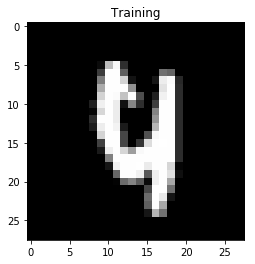

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title('Training')
print(train_y[0].shape)
plt.imshow(train_y[0].reshape(28,28), cmap='gray')

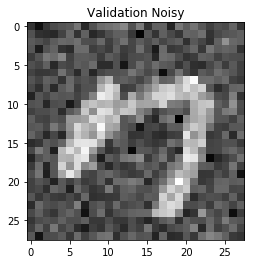

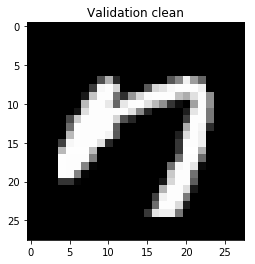

In [5]:
plt.figure()
plt.title('Validation Noisy')
plt.imshow(validation_x[0].reshape(28,28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

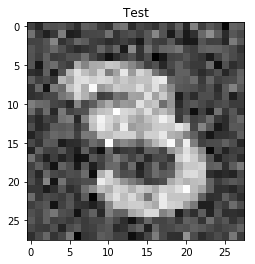

In [6]:
plt.figure()
plt.title('Test')
plt.imshow(test_x[0].reshape(28,28), cmap='gray')

### Calculate standart deviation of gaussian noise

In [7]:
noise = validation_x - validation_y
noise_sigma = np.std(noise)

noise_sigma

0.20003203

### Create a noise generator

In [8]:
def getNoisy(clean, sigma=noise_sigma):
    return clean + sigma * np.random.normal(0, 1, clean.shape)

### Check if we get everything right by adding noise to validation image and displaying it

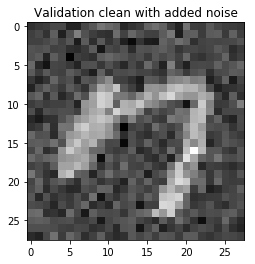

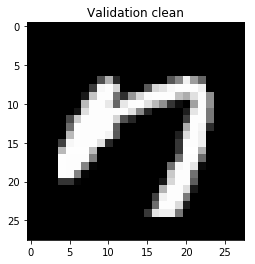

In [9]:
plt.figure()
plt.title('Validation clean with added noise')
plt.imshow(getNoisy(validation_y[0]).reshape(28, 28), cmap='gray')

plt.figure()
plt.title('Validation clean')
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

### Data Augmentation (Bootstrapping)

We don't really want to predict anything so we can go wild and crazy with the transformations (horizontal & vertical flips, random rotations, etc.). As we don't have much computing power however, we will only use flips, as they are pretty fast to compute.

In [10]:
def horizontalFlip(image):
    return np.flip(image, 3)

def verticalFlip(image):
    return np.flip(image, 2)

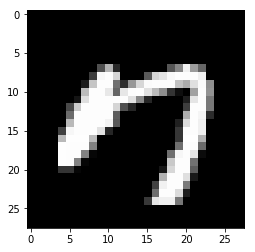

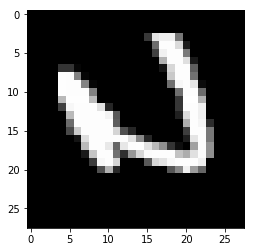

In [11]:
plt.figure("some image")
plt.imshow(validation_y[0].reshape(28,28), cmap='gray')

plt.figure("some vertically flipped image")
plt.imshow(verticalFlip(validation_y)[0].reshape(28,28), cmap='gray')

### Prepare data for training

In [12]:
def get_train_set(train_y):
    # augment data; better for general purpose denoisers, though for MNIST digits it doesn't make too much sense
    
    # train_enhanced = np.vstack([train_y, verticalFlip(train_y)])
    # train_enhanced = np.vstack([train_enhanced, horizontalFlip(train_y)])
    train_enhanced = train_y
    
    # repeat data, as we are going to add different noise to each image, more is more
    train_enhanced = np.repeat(train_enhanced, 5, axis=0)
    # add noise
    train_x = getNoisy(train_enhanced)
    
    return train_x, train_enhanced

## Model

We based our model entirely on residual denoising convolutional NN. Further information can be found in this paper (https://arxiv.org/pdf/1608.03981.pdf). 

#### All hyperparams

In [13]:
input_shape = train_y.shape[1:4]
flat_shape = np.prod(np.array(input_shape))

print('flat shape: ' + str(flat_shape))

flat shape: 784


#### Define Loss, Frobenius norm

In [14]:
def frobenius(yTrue, yPred):
    return np.mean(np.sqrt(np.sum((yTrue - yPred)**2, axis=(1,2,3))))

In [15]:
class PCADenoiser:
    def __init__(self, target_explained_variance):
        self.target_explained_variance = target_explained_variance
        
        # NOTE: the principal components are the columns of the matrix saved here later on
        self.principal_components = None
        # the principal components to be used for denoising
        self.denoising_principal_components = None
        self.denoising_matrix = None
        
        self.mean = 0.
        self.fitted = False
    
    def fit(self, X):
        X = self.flatten(X)
        
        # center
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
        
        
        cov = np.cov(X, rowvar=0, bias=True)
        # NOTE: eig_vectors are in the columns, not in the rows of the returned matrix
        eig_values, eig_vectors = np.linalg.eig(cov)
        self.principal_components = eig_vectors
        # determine how many principal components to take in order to explain enough variance
        total_eig_values_sum = np.sum(eig_values)
        current_eig_values_sum = 0
        take_n = 0
        
        for lambda_i in eig_values:
            if (current_eig_values_sum / total_eig_values_sum >= self.target_explained_variance):
                break
        
            current_eig_values_sum += lambda_i
            take_n += 1
            
        self.denoising_principal_components = self.principal_components[:, 0:take_n]
        R = self.denoising_principal_components
        self.denoising_matrix = R.dot(R.T)
        
        self.fitted = True
            
    def transform(self, X):
        assert self.fitted, "Model is not fitted"
        
        X = self.flatten(X)
        X = X - self.mean
        
        X_hat = X.dot(self.denoising_matrix)
        reconstructed = np.clip(X_hat + self.mean, a_min=0, a_max=1)
        
        return reconstructed.reshape((len(X), *input_shape))
    
    def flatten(self, X):
        return np.reshape(X, (X.shape[0], flat_shape))
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
        

In [16]:
np.random.shuffle(train_y)
X, y = get_train_set(train_y)

## Model evaluation

In [17]:
def evaluate(X, y, var):
    model = PCADenoiser(var)
    prediction = model.fit_transform(X)
    
    return frobenius(y, prediction)

### Find the best amount of explained variance to be used

In [18]:
# implement binary search to get lowest loss possible and return the variance needed for it
def get_best_explained_variance(search_space=(0,1), min_loss_change=0.01):
    lower = search_space[0]
    upper = search_space[1]
    last_loss = None
    last_best_idx = None
    best_var = None

    while (True):
        median = lower + 1. * (upper - lower) / 2
        loss_lower  = last_loss if last_best_idx == 0 else evaluate(X, y, lower)
        loss_median = last_loss if last_best_idx == 1 else evaluate(X, y, median)
        loss_upper  = last_loss if last_best_idx == 2 else evaluate(X, y, upper)
        
        losses = [loss_lower, loss_median, loss_upper]
        new_best_idx = np.argmin(losses)
        new_best = losses[new_best_idx]
        
        # we need to shrink median range
        if last_loss == new_best and last_best_idx == 1:
            lower = median - (median - lower) / 2
            upper = median + (upper - median) / 2
            continue
        elif last_loss is not None and last_loss - new_best < min_loss_change:
            return best_var, new_best
        
        last_loss = new_best
        last_best_idx = new_best_idx
        
        if last_best_idx == 1: # median is best
            lower = median - (median - lower) / 2
            upper = median + (upper - median) / 2
            best_var = median
        elif losses[0] < losses[2]: # lower loss is smaller, need to search in left subspace
            upper = median
            best_var = lower
        else: # search in upper subspace
            lower = median
            best_var = upper
            
        print('Best explained variance: {}; Best loss: {}'.format(best_var, last_loss))
        
    return best_var, last_loss

explained_variance, loss = get_best_explained_variance()

Best explained variance: 0.5; Best loss: 3.389620451869024
Best explained variance: 0.75; Best loss: 2.693446537110249
Best explained variance: 0.625; Best loss: 2.462311517511211
Best explained variance: 0.6875; Best loss: 2.440806867236304
Best explained variance: 0.65625; Best loss: 2.4024334762127504


## Train with best hyperparam (explained variance)

In [19]:
model = PCADenoiser(explained_variance)
model.fit(X)

'Number of principal components used: {}'.format(len(model.denoising_principal_components.T))

'Number of principal components used: 137'

## Let's see what our best effort does with train and validation data

In [20]:
print('Explained variance: {}'.format(explained_variance))
print('Frobenius loss: {}'.format(evaluate(X, y, explained_variance)))

Explained variance: 0.65625
Frobenius loss: 2.4024334762127504


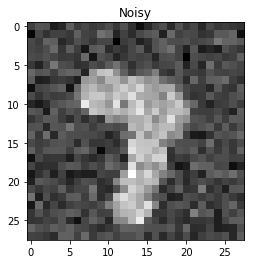

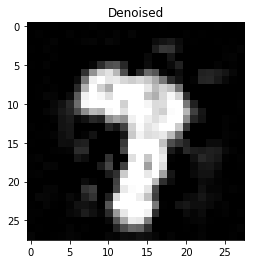

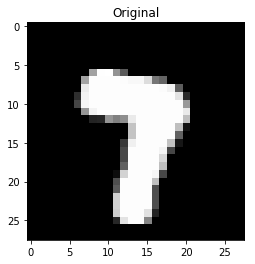

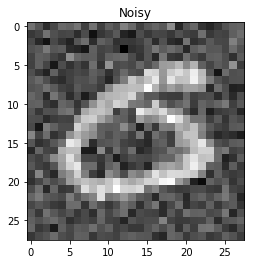

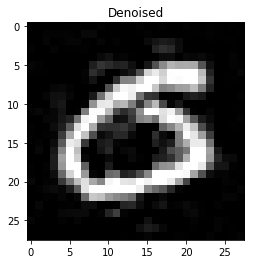

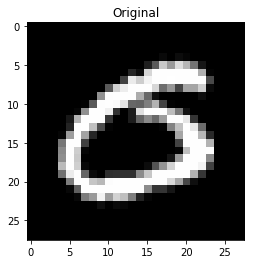

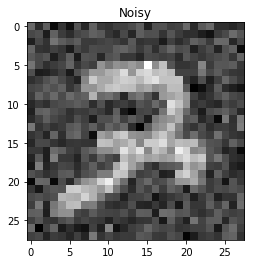

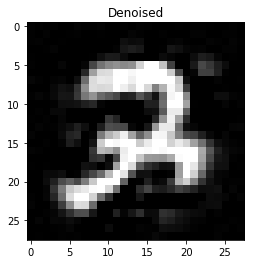

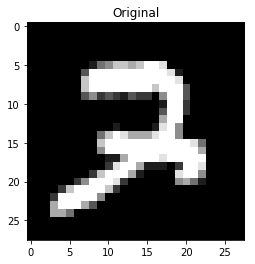

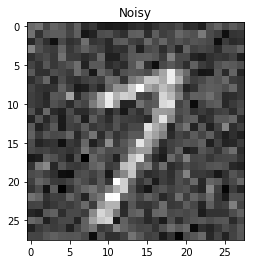

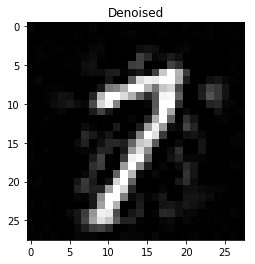

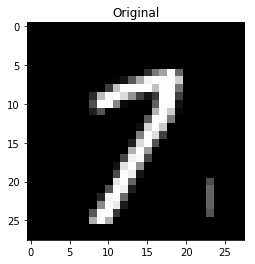

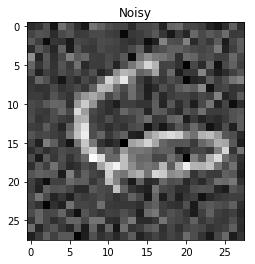

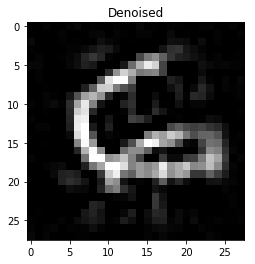

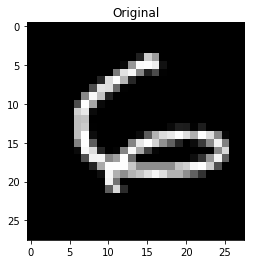

In [21]:
%matplotlib inline

reconstructed = model.transform(X)
idx = np.arange(0, len(X))
np.random.shuffle(idx)

for i in range(5):
    r_i = idx[i]
    
    plt.figure()
    plt.title('Noisy')
    plt.imshow(X[r_i][0], cmap='gray')
    
    plt.figure()
    plt.title('Denoised')
    plt.imshow(reconstructed[r_i][0], cmap='gray')
    
    plt.figure()
    plt.title('Original')
    plt.imshow(y[r_i][0], cmap='gray')

### Do predictions on test data

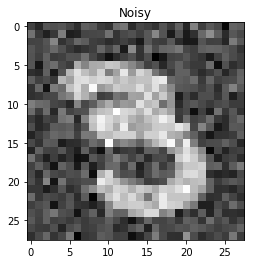

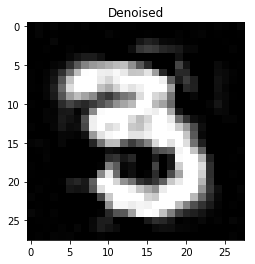

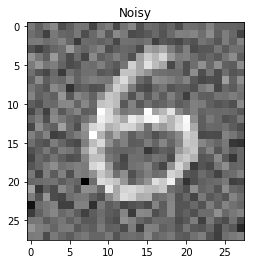

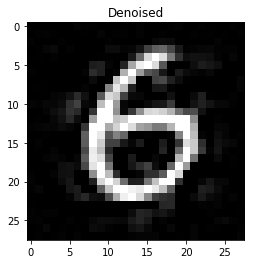

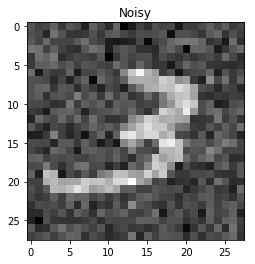

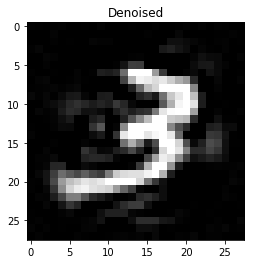

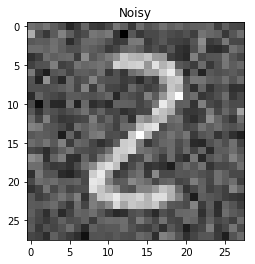

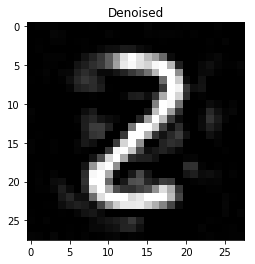

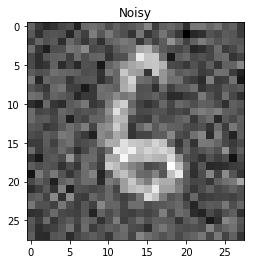

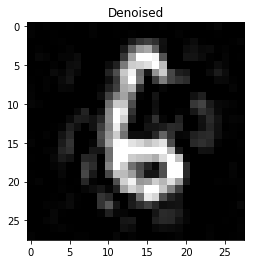

In [22]:
prediction = model.transform(test_x)

for i in range(5):
    plt.figure()
    plt.title('Noisy')
    plt.imshow(test_x[i][0], cmap='gray')
    
    plt.figure()
    plt.title('Denoised')
    plt.imshow(prediction[i][0], cmap='gray')

## Save predictions

In [23]:
np.save('prediction_pca.npy', prediction)